# Практическое задание к модулю 2 (PJ)

- Для закрепления материалов модуля предлагаем выполнить следующий проект. Вам необходимо решить задачу нахождения похожих товаров в интернет-магазинах по их описанию. На практике похожую задачу, например, с помощью организации `kaggle` соревнования решал маркет-плейс [shopee.co.id](https://shopee.co.id/).
- Датасет для выполнения задания — [product-item-data](https://www.kaggle.com/cclark/product-item-data)
- Для каждого `id` товара вам необходимо сформировать список id товаров, которые похожи на него.

Примерный план выполнения проекта:
1. Представить массив текстов в виде векторов (как с помощью `TF-IDF`, так и с помощью `word2vec`);
2. Выберите расстояние, с помощью которого вы будете оценивать близость векторов, представляющих тексты (рекомендуется использовать [косинусное расстояние](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), но вы можете попробовать и другие подходы);
3. Для полученных векторов попарно найдите косинусное расстояние (попробуйте это сделать без цикла, с помощью матричных операций);
4. Задайтесь каким-то порогом значимости (с которым вы сравните значения расстояния между векторами), на основе которого вы будете судить о том, похожи два текста или нет. 

Критерии оценивания проекта:
- общее качество кода и следование `pep8`;
- корректное использование `word2vec` и `tf-idf` для формирования пространства признаков;

In [58]:
from typing import Iterator, List, Tuple

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Get Data

In [8]:
df = pd.read_csv("sample-data.csv").set_index("id")
df.head(10)

,description
id,
1,Active classic boxers - There's a reason why o...
2,Active sport boxer briefs - Skinning up Glory ...
3,Active sport briefs - These superbreathable no...
4,"Alpine guide pants - Skin in, climb ice, switc..."
5,"Alpine wind jkt - On high ridges, steep ice an..."
6,Ascensionist jkt - Our most technical soft she...
7,"Atom - A multitasker's cloud nine, the Atom pl..."
8,Print banded betina btm - Our fullest coverage...
9,Baby micro d-luxe cardigan - Micro D-Luxe is a...


## TF-IDF based model

Create embeddings using model from `sklearn`

In [67]:
tfidf = TfidfVectorizer(stop_words='english')
embeddings_tfidf = tfidf.fit_transform(df['description'].tolist())
embeddings_tfidf.shape

(500, 4600)

Lets see how our embedding look on 2d plane

In [71]:
m = TSNE(init='random', learning_rate='auto', random_state=42)
embed_2d = m.fit_transform(embeddings_tfidf)

Text(0.5, 1.0, 'TF-IDF (TSNE projection)')

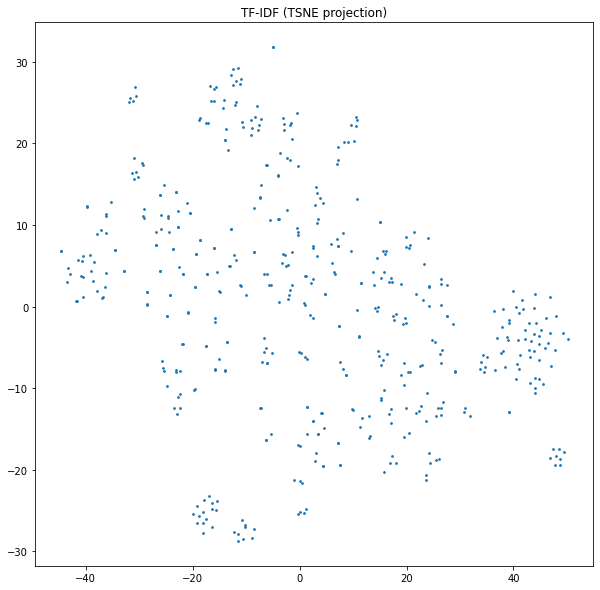

In [72]:
plt.figure(figsize=(10, 10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=3)
plt.title('TF-IDF (TSNE projection)')

Now I am trying to find optimal threshold for similiarity

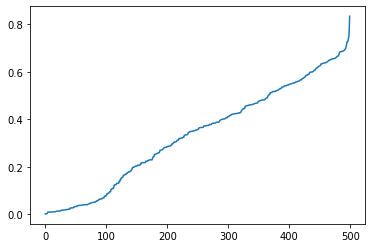

In [73]:
m = NearestNeighbors(
    n_neighbors=2,
    metric='cosine',
    algorithm='brute',
)
nbrs = m.fit(embeddings_tfidf)
distances, indices = nbrs.kneighbors(embeddings_tfidf)

plt.plot(np.sort(distances[:, 1]))

According to plot threshold value is `[0.05, 0.1]`

In [123]:
class Recomendation:
    def __init__(self, embeddings: np.ndarray, items: List[str], threshold: float):
        if len(items) != embeddings.shape[0]:
            raise Exception('Length of embeddings and items should be same')
        self.embeddings = embeddings
        self.items = items
        self.threshold=threshold

    def __call__(self, target_idx: int) -> Iterator[Tuple[int, float, str]]:
        for i in range(self.embeddings.shape[0]):
            if i == target_idx:
                continue
            target = self.get_vector(target_idx)
            item = self.get_vector(i)
            dist = cosine_similarity(target, item)[0][0]
            if dist < self.threshold:
                yield i, dist, self.items[i]
    
    def get_vector(self, idx: int):
        x = self.embeddings[idx]
        if len(x.shape) == 1:
            return np.expand_dims(x, axis=0)
        return x

In [88]:
def pretty(text: str, max_length=100) -> str:
    if len(text) < max_length:
        return text
    return text[:max_length] + '...'

Lets see how recommendation system works on product ID=54

In [108]:
items = df['description'].tolist()
x = 54

print(f'target: {pretty(items[x])}')

model = Recomendation(embeddings_tfidf, items, threshold=0.075)
for idx, dist, suggest in model(target_idx=x):
    print(f'suggest (id={idx}, dist={dist:02f}): {pretty(suggest)}')

target: Hip chest pack - Ready to go vest free? This is the classic alternative. Designed to be worn either ...
suggest (id=13, dist=0.071339): Better sweater jkt - June nights camped out in New Mexico's Navajo country are starry and cold. Laye...
suggest (id=25, dist=0.070174): City by the sea t-shirt - Illustrating the renaissance of sea-inspired, community living, artist Geo...
suggest (id=35, dist=0.066158): Dragoons t-shirt - These dragoons have dropped their weapons in favor of big wave guns. Artist Geoff...
suggest (id=47, dist=0.038093): Going big in b.c. poster - One mans trash is another mans treasure. Orry Grant taking it out on Tras...
suggest (id=67, dist=0.066252): La surfer maria t-shirt - Pray for surf wearing the La Surfer Maria T-Shirt. Inspired by the Virgin ...
suggest (id=68, dist=0.038318): Lead an examined life poster - Guanacos standing sentry in Patagonia, Chile. For 30 years we've paid...
suggest (id=71, dist=0.072853): Live simply deer t-shirt - Adaptability 

## Use word2vec model

In [94]:
import gensim
import gensim.downloader

embeddings = gensim.downloader.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


Create a vector for each document by calculating `mean` of word vectors

In [ ]:
doc_vectors = pd.DataFrame()
for i, row in df.iterrows():
    doc = row['description']
    buffer = pd.DataFrame()
    for word in gensim.utils.simple_preprocess(doc):
        if word in gensim.parsing.preprocessing.STOPWORDS:
            continue
        try:
            word_vec = embeddings[word]
        except:
            continue
        buffer = buffer.append(pd.Series(word_vec), ignore_index=True)
    doc_vectors = doc_vectors.append(buffer.mean(), ignore_index=True)


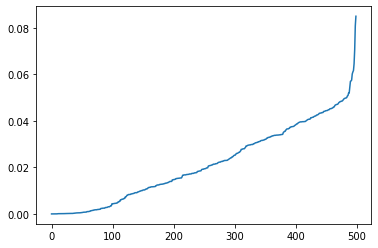

In [125]:
m = NearestNeighbors(
    n_neighbors=2,
    metric='cosine',
    algorithm='brute',
)
x = doc_vectors.to_numpy()
nbrs = m.fit(x)
distances, indices = nbrs.kneighbors(x)

plt.plot(np.sort(distances[:, 1]))

In [134]:
items = df['description'].tolist()
x = 54

print(f'target: {pretty(items[x])}')

model = Recomendation(doc_vectors.to_numpy(), items, threshold=0.8)
for idx, dist, suggest in model(target_idx=x):
    print(f'suggest (id={idx}, dist={dist:02f}): {pretty(suggest)}')


target: Hip chest pack - Ready to go vest free? This is the classic alternative. Designed to be worn either ...
suggest (id=7, dist=0.747576): Print banded betina btm - Our fullest coverage bottoms, the Betina fits highest across the hips with...
suggest (id=47, dist=0.687944): Going big in b.c. poster - One mans trash is another mans treasure. Orry Grant taking it out on Tras...
suggest (id=57, dist=0.781828): '73 logo t-shirt - Soft-wearing ringspun organic cotton; Screen-print inks are PVC- and phthalate-fr...
suggest (id=62, dist=0.789752): Flying fish t-shirt - Soft-wearing ringspun organic cotton; Screen-print inks are PVC- and phthalate...
suggest (id=63, dist=0.785894): Gpiw classic t-shirt - Soft-wearing ringspun organic cotton; Screen-print inks are PVC- and phthalat...
suggest (id=64, dist=0.789816): Live simply guitar t-shirt - Soft-wearing ringspun organic cotton; Screen-print inks are PVC- and ph...
suggest (id=67, dist=0.797458): La surfer maria t-shirt - Pray for surf w

## Result

As we see two models works in different way. But some results (47, 150, 491) are same.